In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
from pathlib import Path

path = Path('data')
train_labels = pd.read_csv(path / 'train_labels.csv')
train_labels

,image_id,InChI
0,000011a64c74,InChI=1S/C13H20OS/c1-9(2)8-15-13-6-5-10(3)7-12...
1,000019cc0cd2,InChI=1S/C21H30O4/c1-12(22)25-14-6-8-20(2)13(1...
2,0000252b6d2b,InChI=1S/C24H23N5O4/c1-14-13-15(7-8-17(14)28-1...
3,000026b49b7e,InChI=1S/C17H24N2O4S/c1-12(20)18-13(14-7-6-10-...
4,000026fc6c36,InChI=1S/C10H19N3O2S/c1-15-10(14)12-8-4-6-13(7...
...,...,...
2424181,ffffe824f539,InChI=1S/C10H12F2N2O3/c1-17-7-2-5(3-8(15)16)9(...
2424182,ffffea1ebdfa,InChI=1S/C19H20F2N4O3S/c1-10(8-20)28-14-7-12(2...
2424183,ffffee2b4534,InChI=1S/C22H26Cl2N2O4S/c1-16-6-2-3-10-21(16)3...
2424184,fffff0b6eea6,InChI=1S/C17H26N2O6S/c1-23-16-12-14(4-5-15(16)...


In [3]:
from src.utils import parse_config_file

config_file = 'debug.yml'
config = parse_config_file(config_file)
config

{'lr': 0.001,
 'optimizer': 'Adam',
 'batch_size': 1,
 'num_workers': 0,
 'pin_memory': True,
 'subset': 0.001,
 'img_size': 128,
 'patch_size': 16,
 'embed_dim': 256,
 'nhead': 4,
 'num_encoder_layers': 4,
 'num_decoder_layers': 4,
 'dropout': 0.1,
 'max_len': 21,
 'load_from': False,
 'train_trans': {'Resize': {'width': 128, 'height': 128}},
 'val_trans': {'Resize': {'width': 128, 'height': 128}},
 'gpus': 1,
 'precision': 16,
 'max_epochs': 50,
 'train_batches': 1,
 'shuffle_train': True,
 'val_batches': 1,
 'val_with_train': True,
 'log': False}

In [4]:
from src.dm import DataModule

dm = DataModule(**config)
dm.setup()

Training samples:  2181
Validation samples:  243


In [5]:
images, inchis = next(iter(dm.train_dataloader()))
images.shape, inchis.shape

(torch.Size([1, 1, 128, 128]), torch.Size([1, 10]))

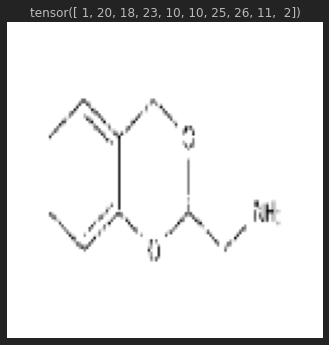

In [6]:
import matplotlib.pyplot as plt
from skimage import io
import random

rows, columns = 1, 1
fig = plt.figure(figsize=(5,5))
ix = 0
for r in range(rows):
    for c in range(columns):
        image = images[ix]
        ax = plt.subplot(rows, columns, ix + 1)
        ax.imshow(image.squeeze(0), cmap="gray")
        ax.axis('off')
        ax.set_title(inchis[ix], size=12)
        ix += 1
plt.tight_layout()
plt.show()

In [7]:
from src.vocab import decode 

decode(inchis[0])

'C9H11NO2'

# Fit one sample

In [14]:
import pytorch_lightning as pl
from src.models import Transformer

config_file = 'debug.yml'
config = parse_config_file(config_file)

dm = DataModule(**config)
model = Transformer(config)

trainer = pl.Trainer(
    gpus=config['gpus'],
    precision=config['precision'],
    max_epochs=20,
    limit_train_batches=config['train_batches'],
    limit_val_batches=config['val_batches']
)

trainer.fit(model, dm)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Using native 16bit precision.

  | Name        | Type           | Params
-----------------------------------------------
0 | patch_embed | PatchEmbedding | 65 K  
1 | trg_emb     | Embedding      | 9 K   
2 | trg_pos_emb | Embedding      | 5 K   
3 | transformer | Transformer    | 7 M   
4 | l           | LayerNorm      | 512   
5 | fc          | Linear         | 10 K  


Training samples:  2181
Validation samples:  243


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

1

In [10]:
preds = model.predict(images)
preds

['C1HH1NN3O']

In [11]:
gt = decode(inchis[0])
gt

'C9H11NO2'

In [12]:
from Levenshtein import distance

distance(preds[0], gt)

5

# Fit one batch

In [ ]:
config['batch_size'] = 10

dm = DataModule(**config)
model = Transformer(config)

trainer = pl.Trainer(
    gpus=config['gpus'],
    precision=config['precision'],
    max_epochs=100,
    limit_train_batches=config['train_batches'],
    limit_val_batches=config['val_batches']
)

trainer.fit(model, dm)

In [ ]:
images, inchis = next(iter(dm.train_dataloader()))
images.shape, inchis.shape

In [ ]:
preds = model.predict(images)
preds

In [ ]:
import torch

x = model(images, inchis)
x = torch.argmax(x, 2)
preds = [decode(pred) for pred in x]
preds

In [ ]:
gts = []
for inchi in inchis:
    gts.append(decode(inchi))
gts

In [ ]:
metrics = []
for pred, gt in zip(preds, gts):
    metrics.append(distance(pred, gt))
np.mean(metrics)